## ARIMAX

This script fits an ARIMAX models to our data to nowcast GDP, using our non-GDP variables as exogenous regressors, and incorporating an autoregressive component (previous values of GDP), moving average component (previous residuals of GDP), and differencing (accounts for non-stationarity). 

First, let's load the packages we need.

In [25]:
# PACKAGES
import pandas as pd
import numpy as np
import statsmodels.api as sm # for arimax
import pmdarima as pm # for arimax with AIC-based automatic order selection
import matplotlib.pyplot as plt


Load data.

In [14]:
data = pd.read_csv("../data/data_wpk.csv")

We'll need a datetime index for this model.

In [15]:
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
data = data.asfreq("QE")

There's some missing values for our exogenous regressors, so let's filter those out.

In [46]:
data_filt = data.loc["2011-03-31" : "2025-06-30"]

Now let's split our data into independent and dependent variables

In [47]:
y = data_filt["gdp"]
X = data_filt.drop(columns=["gdp"])  # everything else = exogenous predictors

In [48]:
# model
arimax_ord_ones = sm.tsa.SARIMAX(
    y,
    exog=X,
    order=(1, 1, 1),   # all order 1 works well for many models
    enforce_stationarity=False,
    enforce_invertibility=False
)

# fit
fitted_arimax_ord_one = arimax_ord_ones.fit()
print(fitted_arimax_ord_one.summary())

                               SARIMAX Results                                
Dep. Variable:                    gdp   No. Observations:                   58
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -457.290
Date:                Sun, 16 Nov 2025   AIC                            938.580
Time:                        14:17:42   BIC                            962.668
Sample:                    03-31-2011   HQIC                           947.895
                         - 06-30-2025                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
orders                 0.9117      0.446      2.046      0.041       0.038       1.785
employment             0.0095      0.003      3.715      0.000       0.005       0.015
consumer_sentiment  

c:\Users\wpken\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Now do nowcasting.

In [49]:
# extract last available values of exogenous regressors
X_next = data.drop(columns=["gdp"]).iloc[-2]  # shape (1, k)
print(X_next) # values we'll nowcast with

orders                3.170000e+01
employment            3.265000e+05
consumer_sentiment    5.833333e+01
unemploy_claims       2.749000e+06
bus_outlook           1.293333e+01
auto_sales            3.369800e+01
construction          2.230530e+05
itrade               -7.831100e+04
wtrade                7.113490e+05
Name: 2025-09-30 00:00:00, dtype: float64


In [50]:
nowcast = fitted_arimax_ord_one.get_forecast(steps=1, exog=X_next)
nowcast_value = nowcast.predicted_mean.iloc[0]
nowcast_ci = nowcast.conf_int().iloc[0]

print("Nowcasted GDP:", nowcast_value)
print("95% CI:")
print(nowcast_ci)

Nowcasted GDP: 20106.901793012807
95% CI:
lower gdp    19837.842323
upper gdp    20375.961263
Name: 2025-09-30 00:00:00, dtype: float64


Plot nowcast value. 

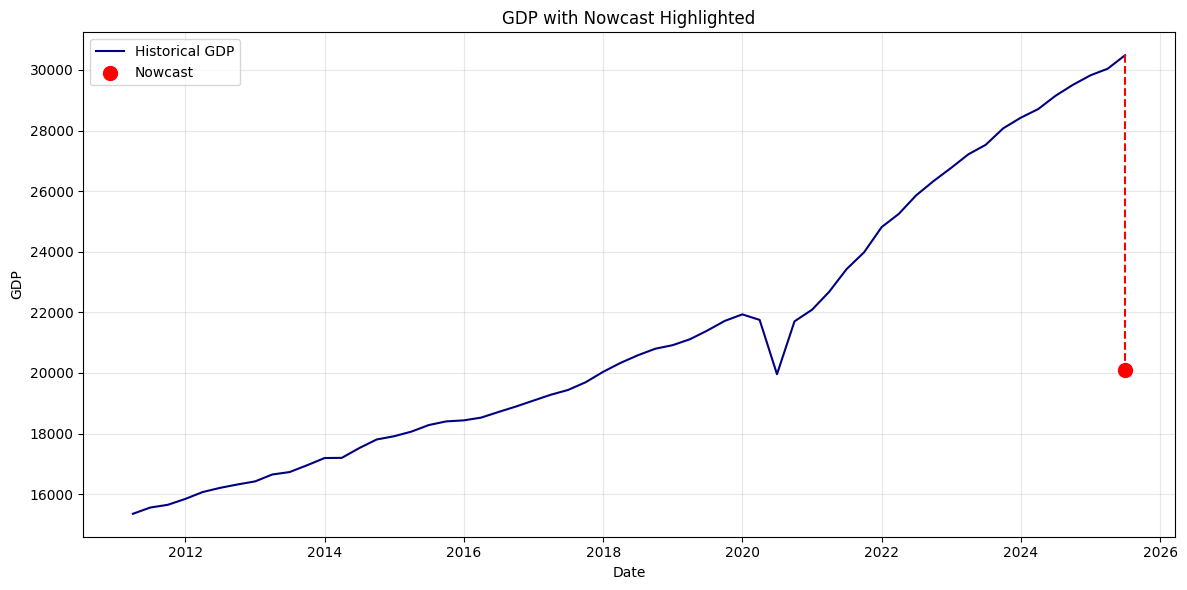

In [ ]:
nowcast_date = pd.to_datetime("2025-06-30")
nowcast_series = pd.Series([nowcast_value], index=[nowcast_date])


plt.figure(figsize=(12, 6))

# plot historical GDP
plt.plot(data_filt.index, data_filt["gdp"], label="Historical GDP", color="navy")

# add the nowcast point
plt.scatter(nowcast_date, nowcast_value, 
            color="red", s=100, zorder=5, label="Nowcast")

# connect last point to nowcast
plt.plot([data_filt.index[-1], nowcast_date], 
         [data_filt["gdp"].iloc[-1], nowcast_value], 
         color="red", linestyle="--")

plt.title("GDP with Nowcast Highlighted")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Now let's try automatically choosing the order values based on the AIC.

In [52]:
auto = pm.auto_arima(
    y, 
    exogenous=X, 
    seasonal=False,
    stepwise=True
)

auto.summary()
order = auto.order

In [53]:
print(order)

(0, 2, 1)


A 0 order for the autoregressive component is kind of shocking? Perhaps it's very highly correlated with our regressors.

In [54]:
# model
arimax_auto_ord = sm.tsa.SARIMAX(
    y,
    exog=X,
    order=order,   # all order 1 works well for many models
    enforce_stationarity=False,
    enforce_invertibility=False
)

# fit
fitted_arimax_auto_ord = arimax_auto_ord.fit()
print(fitted_arimax_auto_ord.summary())

                               SARIMAX Results                                
Dep. Variable:                    gdp   No. Observations:                   58
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -320.462
Date:                Sun, 16 Nov 2025   AIC                            662.924
Time:                        14:18:22   BIC                            684.803
Sample:                    03-31-2011   HQIC                           671.362
                         - 06-30-2025                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
orders                 0.3521      0.651      0.541      0.589      -0.924       1.629
employment             0.0022      0.004      0.585      0.559      -0.005       0.010
consumer_sentiment  

c:\Users\wpken\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Nowcasted GDP: 27960.829533536733
95% CI:
lower gdp    27774.685567
upper gdp    28146.973500
Name: 2025-09-30 00:00:00, dtype: float64


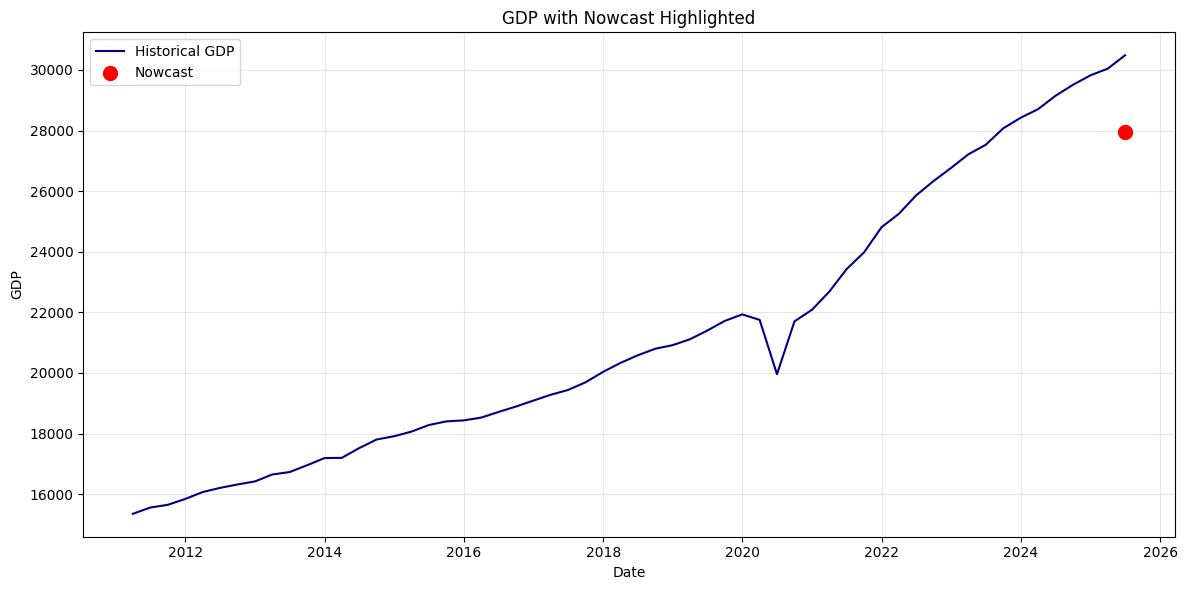

In [56]:
nowcast_auto = fitted_arimax_auto_ord.get_forecast(steps=1, exog=X_next)
nowcast_auto_value = nowcast_auto.predicted_mean.iloc[0]
nowcast_auto_ci = nowcast_auto.conf_int().iloc[0]

print("Nowcasted GDP:", nowcast_auto_value)
print("95% CI:")
print(nowcast_auto_ci)


nowcast_auto_series = pd.Series([nowcast_auto_value], index=[nowcast_date])


plt.figure(figsize=(12, 6))

# plot historical GDP
plt.plot(data_filt.index, data_filt["gdp"], label="Historical GDP", color="navy")

# add the auto chosen nowcast point
plt.scatter(nowcast_date, nowcast_auto_series, 
            color="red", s=100, zorder=5, label="Nowcast")


plt.title("GDP with Nowcast Highlighted")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

These predictions are horrible. Let's try just a simple ARIMA (all the regressors could be clogging up the model).

In [59]:
y = data_filt["gdp"]

# simple ARIMA model — start with all ones
arima_ones = sm.tsa.ARIMA(y, order=(1, 1, 1))
arima_ones_fitted = arima_ones.fit()

print(arima_ones_fitted.summary())

c:\Users\wpken\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\wpken\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                    gdp   No. Observations:                   58
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -420.563
Date:                Sun, 16 Nov 2025   AIC                            847.126
Time:                        14:27:56   BIC                            853.256
Sample:                    03-31-2011   HQIC                           849.508
                         - 06-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    589.808      0.000       0.997       1.003
ma.L1         -0.9971      0.069    -14.405      0.000      -1.133      -0.861
sigma2       1.47e+05   4.83e-07   3.04e+11      0.0

Now to forecast. 

In [60]:
forecast_arima = arima_ones_fitted.get_forecast(steps=1)
nowcast_value_arima = forecast_arima.predicted_mean.iloc[0]
nowcast_ci_arima = forecast_arima.conf_int().iloc[0]


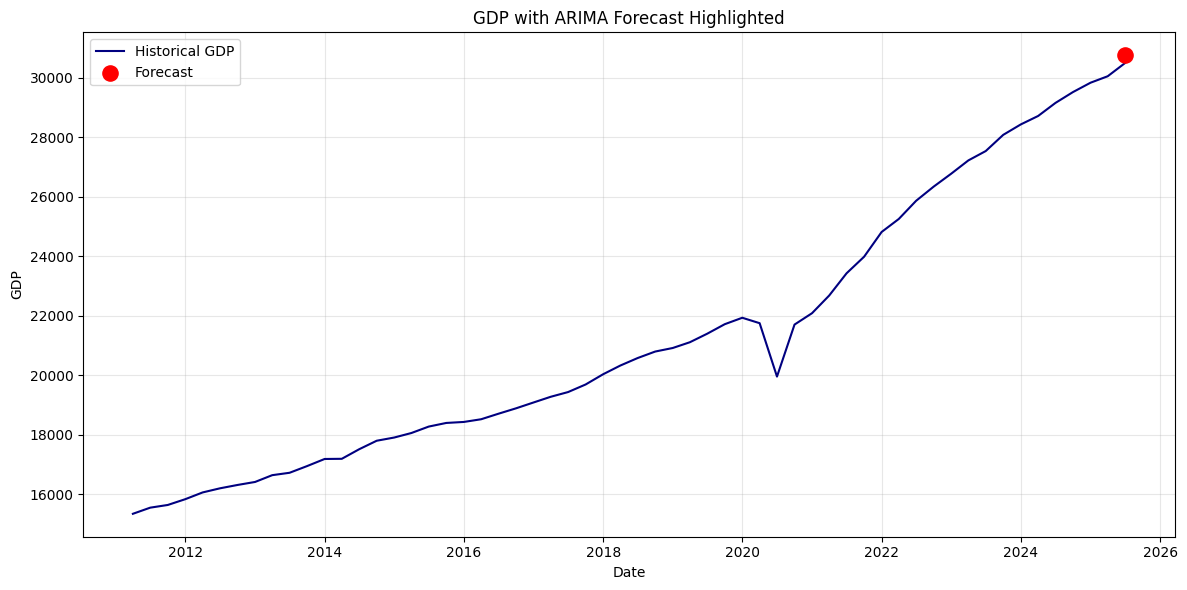

In [61]:
# make a Series for the forecasted value
nowcast_arima_series = pd.Series([nowcast_value_arima], index=[nowcast_date])

plt.figure(figsize=(12, 6))

# plot historical GDP
plt.plot(y.index, y, label="Historical GDP", color="navy")

# plot the forecast point
plt.scatter(nowcast_date, nowcast_value_arima,
            color="red", s=120, zorder=5, label="Forecast")

# dotted line connecting last real value to the forecast
plt.plot([y.index[-1], nowcast_date],
         [y.iloc[-1], nowcast_value_arima],
         color="red", linestyle="--")

plt.title("GDP with ARIMA Forecast Highlighted")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
